In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [2]:
df=pd.read_csv('product h.csv', parse_dates=['Month-Year'])

In [3]:
sales_h= df.drop(['Product Name','Product Category','Month','Year','Market Size', 'Marketing Expense','Month No.'],axis=1)

In [4]:
sales_h.shape

(60, 2)

In [5]:
sales_h.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month-Year  60 non-null     datetime64[ns]
 1   Sales       60 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.1 KB


In [6]:
sales_h['Sales'].sum()

4057933

In [7]:
sales_h = sales_h.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_h.head()

ds      y
0 2019-01-01  62686
1 2019-02-01  74426
2 2019-03-01  91347
3 2019-04-01  60600
4 2019-05-01  37374

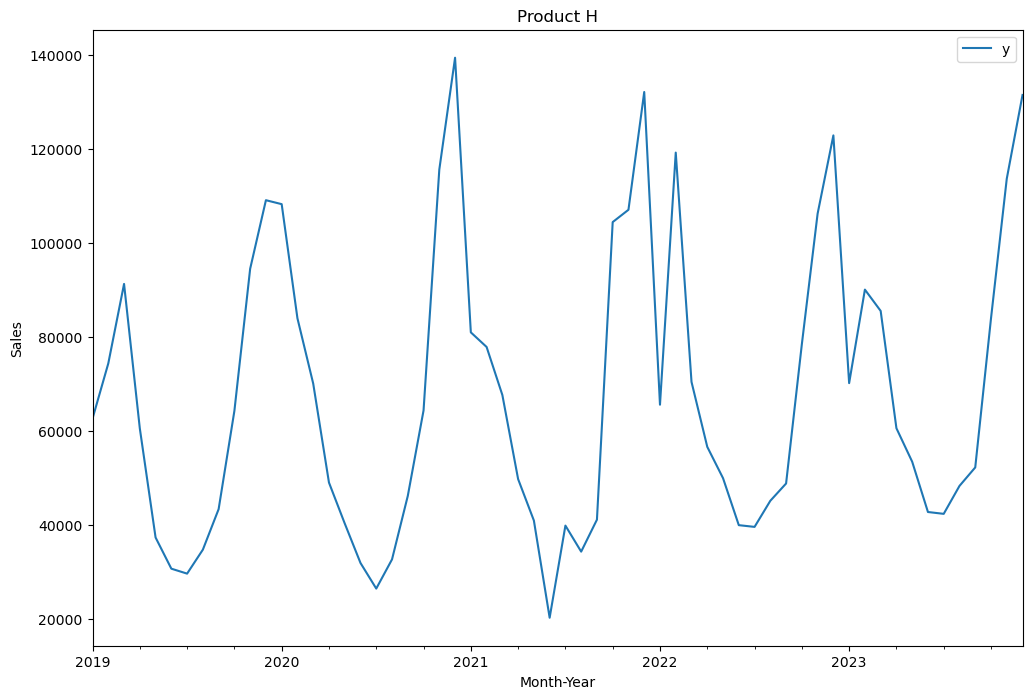

In [8]:
ax = sales_h.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product H')
plt.show()

In [9]:
from statsmodels.tsa.stattools import adfuller

In [10]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [11]:
adf_test(sales_h['y'])

ADF Statistics: -1.0256008967536312
p- value: 0.7438128320877682
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [12]:
train= sales_h[:48]
test=sales_h[48:]

# Hyperparameter Tuning

In [13]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1,0.2, 0.3, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
seasonality_mode_range = ['additive', 'multiplicative']

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range,
    'seasonality_mode' : seasonality_mode_range
}


# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, initial='730 days', period='365 days', horizon = '365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

12:59:32 - cmdstanpy - INFO - Chain [1] start processing
12:59:33 - cmdstanpy - INFO - Chain [1] done processing
12:59:34 - cmdstanpy - INFO - Chain [1] start processing
12:59:34 - cmdstanpy - INFO - Chain [1] done processing
12:59:36 - cmdstanpy - INFO - Chain [1] start processing
12:59:36 - cmdstanpy - INFO - Chain [1] done processing
12:59:38 - cmdstanpy - INFO - Chain [1] start processing
12:59:38 - cmdstanpy - INFO - Chain [1] done processing
12:59:40 - cmdstanpy - INFO - Chain [1] start processing
12:59:40 - cmdstanpy - INFO - Chain [1] done processing
12:59:42 - cmdstanpy - INFO - Chain [1] start processing
12:59:44 - cmdstanpy - INFO - Chain [1] done processing
12:59:46 - cmdstanpy - INFO - Chain [1] start processing
12:59:46 - cmdstanpy - INFO - Chain [1] done processing
12:59:51 - cmdstanpy - INFO - Chain [1] start processing
12:59:51 - cmdstanpy - INFO - Chain [1] done processing
12:59:53 - cmdstanpy - INFO - Chain [1] start processing
12:59:54 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
..                      ...                      ...              ...   
67                    0.500                     3.00   multiplicative   
68                    0.500                     5.00         additive   
69                    0.500                     5.00   multiplicative   
70                    0.500                    10.00         additive   
71                    0.500                    10.00   multiplicative   

            rmse  
0   28304.047705  
1   29529.828476  
2   13280.307909  
3   13695.977514  
4   12938.852507  
..       

In [14]:
tuning_results.sort_values('rmse',ascending=True)

changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
6                     0.001                     3.00         additive   
10                    0.001                    10.00         additive   
46                    0.200                    10.00         additive   
34                    0.100                    10.00         additive   
32                    0.100                     5.00         additive   
..                      ...                      ...              ...   
49                    0.300                     0.01   multiplicative   
37                    0.200                     0.01   multiplicative   
61                    0.500                     0.01   multiplicative   
25                    0.100                     0.01   multiplicative   
1                     0.001                     0.01   multiplicative   

            rmse  
6   12628.568846  
10  12777.575986  
46  12833.490347  
34  12837.146501  
32  12838.379512  
..           ...  
49  29015.956067  
37  29019.606170  
61  29022.087103  
25  29036.324031  
1   29529.828476  

[72 rows x 4 columns]

In [15]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 3.0, 'seasonality_mode': 'additive'}


In [16]:
# Create a Prophet model
model = Prophet( changepoint_prior_scale= 0.001,seasonality_prior_scale=3.00, seasonality_mode = 'additive',
                interval_width=0.95)

In [17]:
model.fit(train)

13:03:06 - cmdstanpy - INFO - Chain [1] start processing
13:03:06 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 12 months in 2023

In [19]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [20]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

In [21]:
forecasted_df

ds           yhat     yhat_lower     yhat_upper
48 2023-01-01   91269.718962   74211.486097  109426.606168
49 2023-02-01   94819.728449   78561.798059  112902.754687
50 2023-03-01   86857.003766   69454.027478  104770.498878
51 2023-04-01   61606.800451   43390.129305   78624.654889
52 2023-05-01   44132.661363   27730.745870   61422.265593
53 2023-06-01   36582.943504   18360.632008   54010.128388
54 2023-07-01   41126.790512   24219.843962   58313.388131
55 2023-08-01   47561.705825   28603.189164   64507.759237
56 2023-09-01   55448.763386   37821.055100   73154.755218
57 2023-10-01   86035.265337   67707.748629  103002.242222
58 2023-11-01  108559.234282   91594.670382  125763.516671
59 2023-12-01  122318.362705  104241.615658  139628.860826

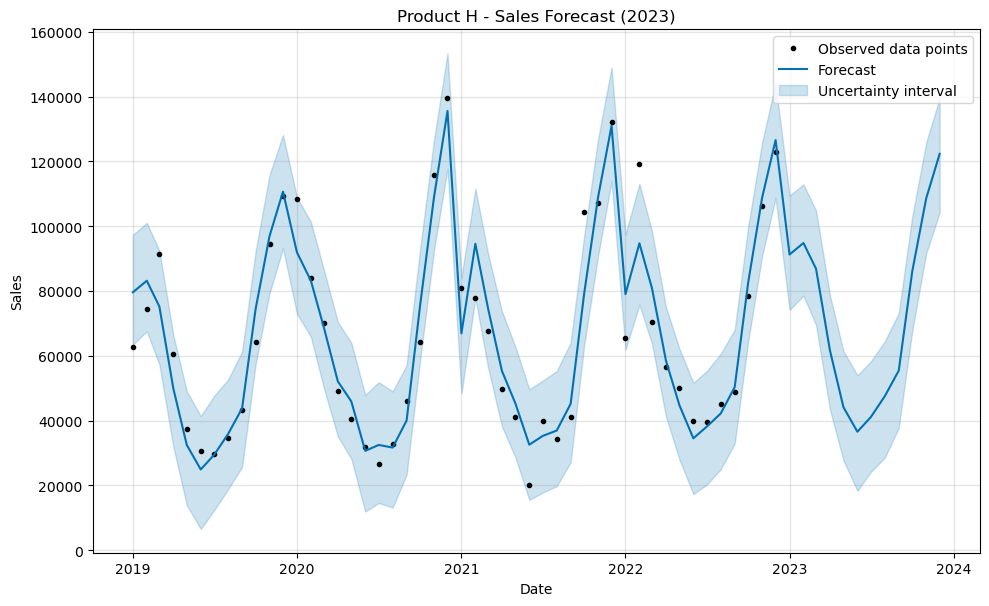

In [22]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product H - Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

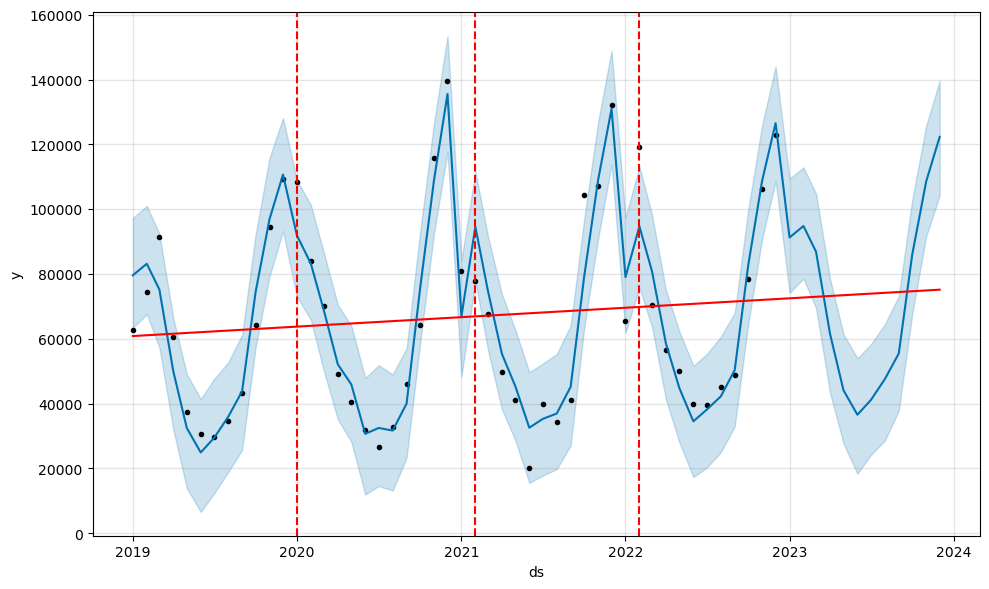

In [43]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

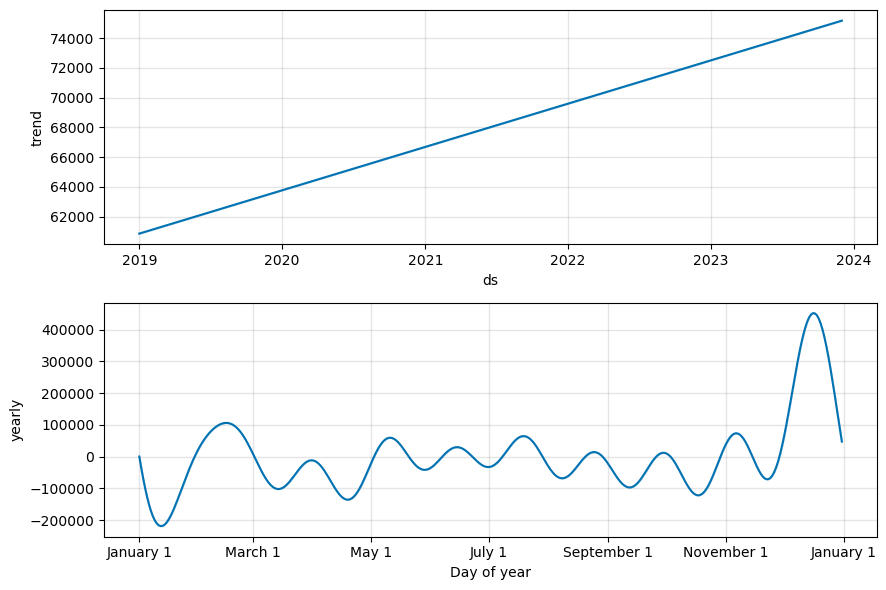

In [23]:
fig2 = model.plot_components(forecast)

In [24]:
forecasted_df

ds           yhat     yhat_lower     yhat_upper
48 2023-01-01   91269.718962   74211.486097  109426.606168
49 2023-02-01   94819.728449   78561.798059  112902.754687
50 2023-03-01   86857.003766   69454.027478  104770.498878
51 2023-04-01   61606.800451   43390.129305   78624.654889
52 2023-05-01   44132.661363   27730.745870   61422.265593
53 2023-06-01   36582.943504   18360.632008   54010.128388
54 2023-07-01   41126.790512   24219.843962   58313.388131
55 2023-08-01   47561.705825   28603.189164   64507.759237
56 2023-09-01   55448.763386   37821.055100   73154.755218
57 2023-10-01   86035.265337   67707.748629  103002.242222
58 2023-11-01  108559.234282   91594.670382  125763.516671
59 2023-12-01  122318.362705  104241.615658  139628.860826

In [25]:
sales_h.tail(12) 

ds       y
48 2023-01-01   70232
49 2023-02-01   90139
50 2023-03-01   85600
51 2023-04-01   60633
52 2023-05-01   53500
53 2023-06-01   42800
54 2023-07-01   42408
55 2023-08-01   48352
56 2023-09-01   52288
57 2023-10-01   84019
58 2023-11-01  113741
59 2023-12-01  131572

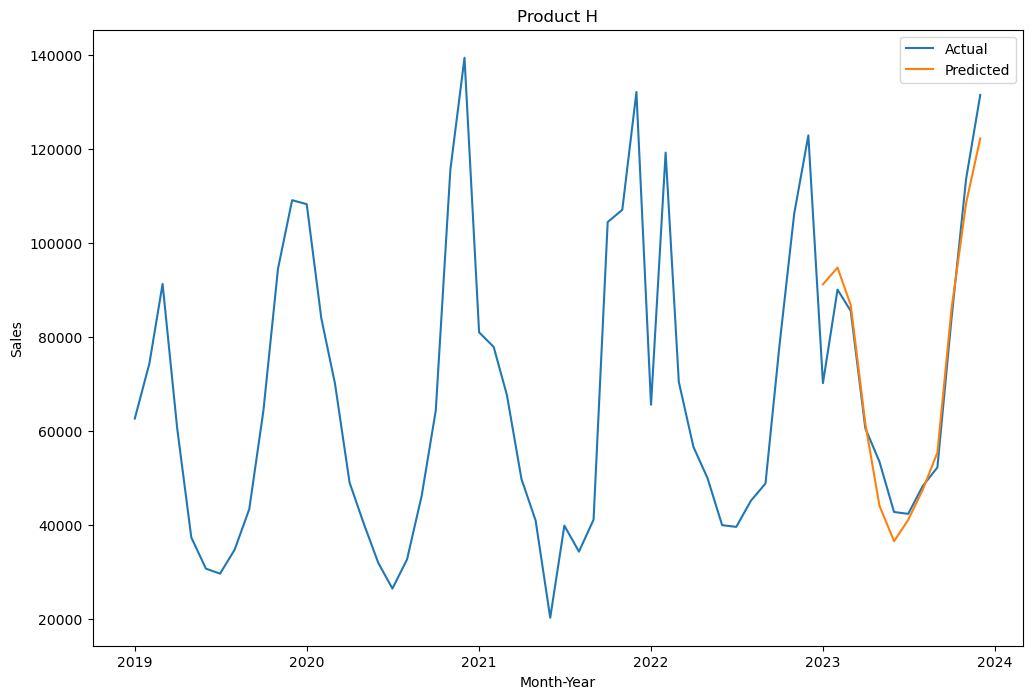

In [26]:
# Reset index of sales_b DataFrame
sales_h_reset_index = sales_h.reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(sales_h_reset_index['ds'], sales_h_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product H')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [27]:
#model evaluation

In [28]:
pred=forecasted_df['yhat']
test_df=test['y']

In [29]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 5434.799
MAPE - FB PROPHET: 0.079
MSE - FB PROPHET: 60185360.100
RMSE - FB PROPHET: 7757.922


In [30]:
# train data: 0 to 47 --> Jan-2019 to Dec-2022
# test data: 48: 59 --> Jan 2023 to Dec-2023

#sales_b['y'].plot(figsize=(12,8))
#forecast_df['yhat'].plot()
#plt.title('Product B')
#plt.xlabel('Month')
#plt.ylabel('Sales')
#plt.legend(labels=['Actual', 'Predicted'])
#plt.show()

# Cross Validation

In [31]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='365 days', horizon='365 days', parallel="processes")

In [32]:
df_p = performance_metrics(df_cv)
df_p

horizon           mse          rmse           mae      mape     mdape  \
0   31 days  3.334930e+08  18261.791354  18261.791354  0.278220  0.278220   
1   62 days  1.114285e+09  33380.907454  33380.907454  0.279797  0.279797   
2   90 days  2.542870e+08  15946.379859  15946.379859  0.226209  0.226209   
3  121 days  9.634644e+06   3103.972267   3103.972267  0.054776  0.054776   
4  151 days  6.421315e+07   8013.310769   8013.310769  0.160266  0.160266   
5  182 days  4.970718e+07   7050.332096   7050.332096  0.176258  0.176258   
6  212 days  5.179975e+05    719.720441    719.720441  0.018160  0.018160   
7  243 days  4.384812e+06   2093.994377   2093.994377  0.046339  0.046339   
8  274 days  1.734075e+07   4164.222299   4164.222299  0.085214  0.085214   
9  304 days  4.903192e+07   7002.279972   7002.279972  0.089176  0.089176   
10 335 days  8.647102e+06   2940.595571   2940.595571  0.027663  0.027663   
11 365 days  8.226416e+06   2868.172997   2868.172997  0.023325  0.023325   

       smape  coverage  
0   0.244243       0.0  
1   0.325307       0.0  
2   0.203224       1.0  
3   0.053315       1.0  
4   0.174228       1.0  
5   0.193293       1.0  
6   0.018326       1.0  
7   0.047438       1.0  
8   0.081731       1.0  
9   0.085370       1.0  
10  0.027286       1.0  
11  0.023056       1.0

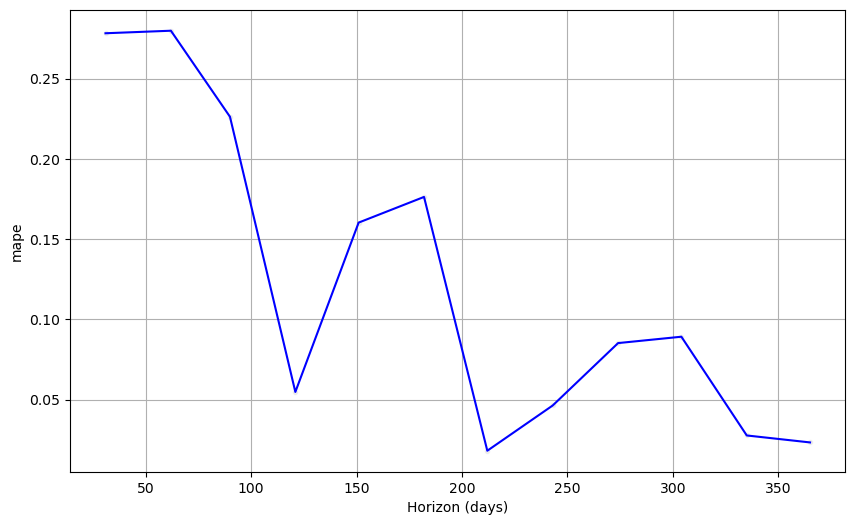

In [33]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

# FORECASTING

In [34]:
model_forecast = Prophet( changepoint_prior_scale= 0.001,seasonality_prior_scale=3.00, seasonality_mode = 'additive',
                interval_width=0.95)

In [35]:
model_forecast.fit(sales_h)

13:03:57 - cmdstanpy - INFO - Chain [1] start processing
13:03:57 - cmdstanpy - INFO - Chain [1] done processing


In [36]:
# Create a DataFrame for future dates 
future_dates_f = model_forecast.make_future_dataframe(periods=12, freq='MS')  # 12 months in 2024

In [37]:
# Make predictions for the future
forecast_f = model_forecast.predict(future_dates_f)

In [38]:
forecasted_f_df=forecast_f[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

In [39]:
forecasted_f_df

ds           yhat     yhat_lower     yhat_upper
60 2024-01-01   96016.895217   78969.257114  111514.286105
61 2024-02-01   94047.531847   77394.310294  110613.331578
62 2024-03-01   80889.573077   65632.222572   97087.292149
63 2024-04-01   64266.455780   47011.717989   80261.315519
64 2024-05-01   57051.404527   41151.234986   73399.649736
65 2024-06-01   42641.274656   26700.185998   58566.955059
66 2024-07-01   44957.887605   27978.965009   61287.317276
67 2024-08-01   44427.141099   28372.705872   61013.660330
68 2024-09-01   52786.427262   36531.091245   68989.756888
69 2024-10-01   87550.025633   70123.257530  103718.966514
70 2024-11-01  119457.569700  102887.619023  136074.130890
71 2024-12-01  144803.593787  127760.648190  160030.980422

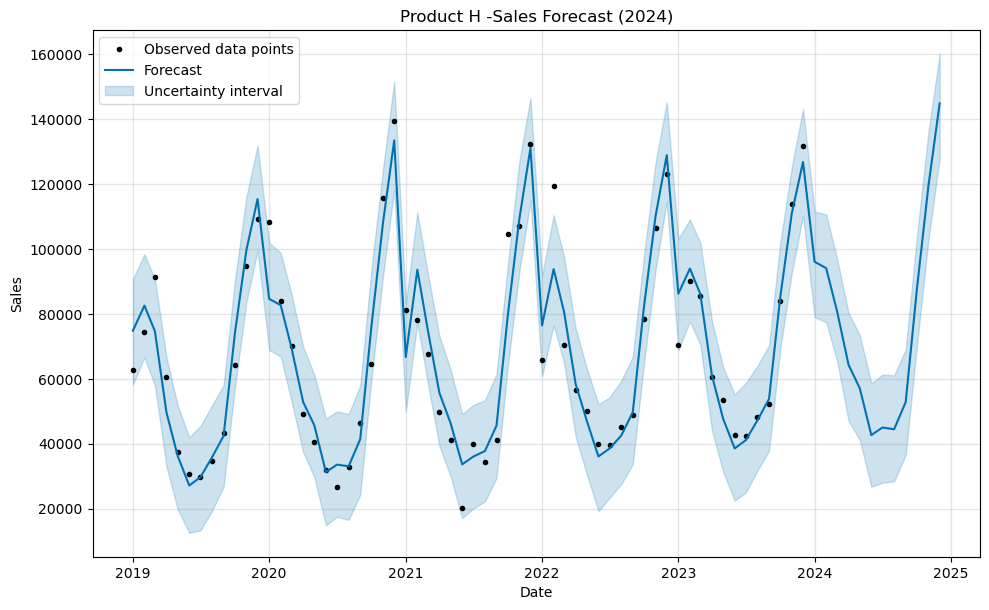

In [40]:
fig = model_forecast.plot(forecast_f, include_legend=True, uncertainty=True)
plt.title('Product H -Sales Forecast (2024)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [41]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model_forecast,forecast_f)

In [42]:
plot_components_plotly(model_forecast, forecast_f)